#### Prueba BBVA.
##### Daniel Cordoba Pulido

#### Analisis descriptivo tabla:

##### Antes de generar un analisis descriptivo lo mejor siempre es evaluar la calidad de los datos con los que vamos a trabajar:

In [1]:
import pandas as pd
import numpy as np
import unicodedata
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (roc_auc_score, classification_report, 
                              confusion_matrix, roc_curve, auc, 
                              precision_recall_curve)
import xgboost as xgb
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
tabla_1 = pd.read_csv("data_prueba.csv",sep=";", encoding='latin-1')

In [3]:
tabla_1

,cedula,oficina,categori,tiempode,monto,saldo,plazo,tasa,cuota,garantia,...,estadoci,sexo,personas,tipovivi,tipocont,aportes,numerocr,antigcoo,default,Cat
0,6754,C80D,E,63,500000.0,411775.0,18,3.1667,36868,P,...,Unión Libre,Masculino,0,NaN,NaN,69000.0,1,6,Malo,E
1,17922,C87A,E,65,2000000.0,1563604.0,24,3.2083,120761,P,...,Soltero,Masculino,0,NaN,NaN,0.0,1,6,Malo,E
2,167,C85Z,E,60,800000.0,658843.0,18,3.1667,58990,P,...,Soltero,Femenino,0,NaN,NaN,82000.0,1,5,Malo,E
3,23093,C80D,E,57,800000.0,744568.0,21,3.2083,52945,P,...,Casado,Masculino,0,Familiar,Término Indefinido,82000.0,1,5,Malo,E
4,16530,C85Z,E,58,14153655.0,13567368.0,48,2.8750,547318,R,...,Casado,Masculino,2,Propia,NaN,300000.0,1,7,Malo,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24781,7,C87A,A,20,6000000.0,2719389.0,36,2.0000,210640,P,...,Casado,Masculino,3,Familiar,Término Indefinido,6000.0,1,2,Bueno,A
24782,6,CE44,A,8,12000000.0,10726957.0,48,2.0834,397891,R,...,Unión Libre,Masculino,1,Familiar,Término Indefinido,131000.0,3,4,Bueno,A
24783,5,C78C,A,14,2000000.0,966688.0,24,2.1742,108602,P,...,Soltero,Masculino,0,Propia,Término Indefinido,0.0,3,7,Bueno,A
24784,4,C80D,A,5,900000.0,684264.0,18,2.1742,60991,P,...,Soltero,Masculino,0,NaN,Término Indefinido,0.0,1,1,Bueno,A


In [4]:
# Cantidad de NAs por columna
tabla_1.isna().sum()


cedula         0
oficina        0
categori       0
tiempode       0
monto          0
saldo          0
plazo          0
tasa           0
cuota          0
garantia       0
diasmora       0
formapag       0
reestruc       0
edad           0
ocupació       0
niveledu       0
ingtot         0
egrtot         0
estrato        0
antigemp       0
estadoci       0
sexo           0
personas       0
tipovivi    4372
tipocont    5191
aportes        0
numerocr       0
antigcoo       0
default        0
Cat            0
dtype: int64

In [5]:
# Eliminar cualquier fila que tenga al menos un NA
tabla_2 = tabla_1.dropna()

In [6]:
tabla_2["default_dicotomic"] = np.where(tabla_2["default"]=="Malo",1,0)

D:\Programas\Anaconda\envs\myenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
tabla_2.describe(include='number')

,cedula,tiempode,monto,saldo,plazo,tasa,cuota,diasmora,formapag,reestruc,edad,ingtot,egrtot,estrato,antigemp,personas,aportes,numerocr,antigcoo,default_dicotomic
count,17676.000000,17676.000000,1.767600e+04,1.767600e+04,17676.000000,17676.00000,1.767600e+04,17676.000000,17676.000000,17676.000000,17676.000000,1.767600e+04,1.767600e+04,17676.000000,17676.000000,17676.000000,1.767600e+04,17676.000000,17676.000000,17676.000000
mean,12413.308101,8.270027,3.119881e+06,2.394656e+06,27.698518,2.16942,1.417632e+05,6.887475,1.099570,1.999265,39.838934,1.051969e+06,4.255030e+05,2.786490,8.765784,1.384872,8.549012e+04,2.188730,3.052387,0.003677
std,7148.288469,7.239387,2.954954e+06,2.575919e+06,11.111966,0.05052,9.125641e+04,33.806308,0.299434,0.027110,10.328912,7.481675e+05,3.890976e+05,0.791476,8.094388,1.224611,9.548571e+04,1.259631,2.572991,0.060531
min,1.000000,-11.000000,1.010830e+05,3.500000e+01,2.000000,0.50000,2.631200e+04,0.000000,1.000000,1.000000,19.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000
25%,6275.750000,3.000000,1.500000e+06,9.077540e+05,18.000000,2.17420,9.148200e+04,0.000000,1.000000,2.000000,32.000000,6.039432e+05,2.000000e+05,2.000000,3.000000,0.000000,1.550000e+04,1.000000,1.000000,0.000000
50%,12377.500000,6.000000,2.300000e+06,1.729070e+06,24.000000,2.17420,1.189970e+05,0.000000,1.000000,2.000000,39.000000,8.556300e+05,3.200000e+05,3.000000,7.000000,1.000000,3.400000e+04,2.000000,2.000000,0.000000
75%,18608.500000,13.000000,4.000000e+06,2.955454e+06,36.000000,2.17420,1.626592e+05,7.000000,1.000000,2.000000,47.000000,1.250000e+06,5.138410e+05,3.000000,12.000000,2.000000,1.550000e+05,3.000000,4.000000,0.000000
max,24783.000000,67.000000,6.100000e+07,5.931241e+07,180.000000,3.30000,2.080188e+06,1670.000000,2.000000,2.000000,83.000000,1.510000e+07,1.180000e+07,6.000000,44.000000,25.000000,1.463000e+06,15.000000,39.000000,1.000000


In [8]:
tabla_1['default'].value_counts()

Bueno    24334
Malo       452
Name: default, dtype: int64

In [9]:
tabla_2['default'].value_counts()

Bueno    17611
Malo        65
Name: default, dtype: int64

In [10]:
del tabla_2

In [11]:
65/(17611+65)

0.0036773025571396243

In [12]:
452/(24334+452)

0.01823610102477205

In [13]:
0.01823610102477205/0.0036773025571396243

4.959097257136473

#### No es una opcion viable retirar las filas con informacion faltante en las columnas (tipovivi/tipocont), ya que si retiracemos, la tasa de personas consideradas "Malas" se reduce casi 5 veces. Lo que quiere decir que un modelo ajustado con este cambio no estaria ajustado a la realidad.

### Tratamiento valores Nulos:

In [14]:
tabla_1["tipovivi"].fillna('Sin_Informacion', inplace=True)
tabla_1["tipocont"].fillna('Sin_Informacion', inplace=True)
tabla_1["default_dicotomic"] = np.where(tabla_1["default"]=="Malo",1,0)

In [15]:
tabla_1

,cedula,oficina,categori,tiempode,monto,saldo,plazo,tasa,cuota,garantia,...,sexo,personas,tipovivi,tipocont,aportes,numerocr,antigcoo,default,Cat,default_dicotomic
0,6754,C80D,E,63,500000.0,411775.0,18,3.1667,36868,P,...,Masculino,0,Sin_Informacion,Sin_Informacion,69000.0,1,6,Malo,E,1
1,17922,C87A,E,65,2000000.0,1563604.0,24,3.2083,120761,P,...,Masculino,0,Sin_Informacion,Sin_Informacion,0.0,1,6,Malo,E,1
2,167,C85Z,E,60,800000.0,658843.0,18,3.1667,58990,P,...,Femenino,0,Sin_Informacion,Sin_Informacion,82000.0,1,5,Malo,E,1
3,23093,C80D,E,57,800000.0,744568.0,21,3.2083,52945,P,...,Masculino,0,Familiar,Término Indefinido,82000.0,1,5,Malo,E,1
4,16530,C85Z,E,58,14153655.0,13567368.0,48,2.8750,547318,R,...,Masculino,2,Propia,Sin_Informacion,300000.0,1,7,Malo,E,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24781,7,C87A,A,20,6000000.0,2719389.0,36,2.0000,210640,P,...,Masculino,3,Familiar,Término Indefinido,6000.0,1,2,Bueno,A,0
24782,6,CE44,A,8,12000000.0,10726957.0,48,2.0834,397891,R,...,Masculino,1,Familiar,Término Indefinido,131000.0,3,4,Bueno,A,0
24783,5,C78C,A,14,2000000.0,966688.0,24,2.1742,108602,P,...,Masculino,0,Propia,Término Indefinido,0.0,3,7,Bueno,A,0
24784,4,C80D,A,5,900000.0,684264.0,18,2.1742,60991,P,...,Masculino,0,Sin_Informacion,Término Indefinido,0.0,1,1,Bueno,A,0


In [16]:
tabla_1.to_csv("tabla_corregida.csv",sep="|",index=False)

#### Desarrollo del Modelo:

#### Transformaciones propuestas para el modelo predictivo:


##### Para construir un modelo predictivo robusto, se plantean las siguientes transformaciones sobre los datos:

* Codificación de variables categóricas: Generar variables dummy para todas las variables categóricas presentes en la tabla, permitiendo así su correcta interpretación por el modelo.

* Transformación logarítmica: Aplicar transformaciones logarítmicas a las variables numéricas cuyas escalas son significativamente superiores a las de otras variables, tales como monto, aportes e ingreso total, entre otras. Esto permitirá normalizar las magnitudes y mejorar el desempeño del modelo.

In [17]:
tabla_1.head(5)

,cedula,oficina,categori,tiempode,monto,saldo,plazo,tasa,cuota,garantia,...,sexo,personas,tipovivi,tipocont,aportes,numerocr,antigcoo,default,Cat,default_dicotomic
0,6754,C80D,E,63,500000.0,411775.0,18,3.1667,36868,P,...,Masculino,0,Sin_Informacion,Sin_Informacion,69000.0,1,6,Malo,E,1
1,17922,C87A,E,65,2000000.0,1563604.0,24,3.2083,120761,P,...,Masculino,0,Sin_Informacion,Sin_Informacion,0.0,1,6,Malo,E,1
2,167,C85Z,E,60,800000.0,658843.0,18,3.1667,58990,P,...,Femenino,0,Sin_Informacion,Sin_Informacion,82000.0,1,5,Malo,E,1
3,23093,C80D,E,57,800000.0,744568.0,21,3.2083,52945,P,...,Masculino,0,Familiar,Término Indefinido,82000.0,1,5,Malo,E,1
4,16530,C85Z,E,58,14153655.0,13567368.0,48,2.8750,547318,R,...,Masculino,2,Propia,Sin_Informacion,300000.0,1,7,Malo,E,1


In [18]:
tabla_1.columns

Index(['cedula', 'oficina', 'categori', 'tiempode', 'monto', 'saldo', 'plazo',
       'tasa', 'cuota', 'garantia', 'diasmora', 'formapag', 'reestruc', 'edad',
       'ocupació', 'niveledu', 'ingtot', 'egrtot', 'estrato', 'antigemp',
       'estadoci', 'sexo', 'personas', 'tipovivi', 'tipocont', 'aportes',
       'numerocr', 'antigcoo', 'default', 'Cat', 'default_dicotomic'],
      dtype='object')

In [19]:
tabla_1.tipovivi.value_counts()


Propia             10326
Familiar            6366
Sin_Informacion     4372
Arrendada           3722
Name: tipovivi, dtype: int64

In [20]:
# Supongamos que tienes tu DataFrame
columnas_a_dicotomizar = ['tipovivi', 'tipocont', 'sexo', 'categori','estadoci', 
                          'oficina', 'garantia', 'ocupació', 'niveledu', 'estrato']

# Dicotomización con prefijo
tabla_1A = pd.get_dummies(tabla_1, columns=columnas_a_dicotomizar, 
                    prefix=columnas_a_dicotomizar, 
                    drop_first=False, 
                    dtype=int)



# Función para normalizar nombres de columnas
def normalizar_columna(nombre):
    # Remover tildes
    nombre = unicodedata.normalize('NFD', nombre)
    nombre = ''.join(char for char in nombre if unicodedata.category(char) != 'Mn')
    # Reemplazar espacios por guiones bajos
    nombre = nombre.replace(' ', '_')
    # Convertir a minúsculas (opcional)
    nombre = nombre.lower()
    return nombre

# Aplicar normalización a todas las columnas
tabla_1A.columns = [normalizar_columna(col) for col in tabla_1A.columns]

# Ver las nuevas columnas creadas
print(tabla_1A.columns)
print(tabla_1A.shape)

Index(['cedula', 'tiempode', 'monto', 'saldo', 'plazo', 'tasa', 'cuota',
       'diasmora', 'formapag', 'reestruc', 'edad', 'ingtot', 'egrtot',
       'antigemp', 'personas', 'aportes', 'numerocr', 'antigcoo', 'default',
       'cat', 'default_dicotomic', 'tipovivi_arrendada', 'tipovivi_familiar',
       'tipovivi_propia', 'tipovivi_sin_informacion', 'tipocont_jubilados',
       'tipocont_servicios', 'tipocont_sin_informacion',
       'tipocont_termino_definido', 'tipocont_termino_indefinido',
       'sexo_femenino', 'sexo_masculino', 'categori_a', 'categori_b',
       'categori_c', 'categori_d', 'categori_e', 'estadoci_casado',
       'estadoci_eclesiastico', 'estadoci_separado', 'estadoci_soltero',
       'estadoci_union_libre', 'estadoci_viudo', 'oficina_c78c',
       'oficina_c80d', 'oficina_c84a', 'oficina_c85z', 'oficina_c87a',
       'oficina_c87z', 'oficina_c89d', 'oficina_ce44', 'oficina_ci58',
       'garantia_p', 'garantia_r', 'ocupacio_ama_de_casa',
       'ocupacio_desempl

In [21]:
tabla_1A['monto_log'] = np.where(tabla_1A['monto'] > 0, np.log(tabla_1A['monto']), 0)
tabla_1A['saldo_log'] = np.where(tabla_1A['saldo'] > 0, np.log(tabla_1A['saldo']), 0)
tabla_1A['aportes_log'] = np.where(tabla_1A['aportes'] > 0, np.log(tabla_1A['aportes']), 0)
tabla_1A['ingtot_log'] = np.where(tabla_1A['ingtot'] > 0, np.log(tabla_1A['ingtot']), 0)
tabla_1A['egrtot_log'] = np.where(tabla_1A['egrtot'] > 0, np.log(tabla_1A['egrtot']), 0)
tabla_1A['cuota_log'] = np.where(tabla_1A['cuota'] > 0, np.log(tabla_1A['cuota']), 0)

D:\Programas\Anaconda\envs\myenv\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [22]:
tabla_1A.columns

Index(['cedula', 'tiempode', 'monto', 'saldo', 'plazo', 'tasa', 'cuota',
       'diasmora', 'formapag', 'reestruc', 'edad', 'ingtot', 'egrtot',
       'antigemp', 'personas', 'aportes', 'numerocr', 'antigcoo', 'default',
       'cat', 'default_dicotomic', 'tipovivi_arrendada', 'tipovivi_familiar',
       'tipovivi_propia', 'tipovivi_sin_informacion', 'tipocont_jubilados',
       'tipocont_servicios', 'tipocont_sin_informacion',
       'tipocont_termino_definido', 'tipocont_termino_indefinido',
       'sexo_femenino', 'sexo_masculino', 'categori_a', 'categori_b',
       'categori_c', 'categori_d', 'categori_e', 'estadoci_casado',
       'estadoci_eclesiastico', 'estadoci_separado', 'estadoci_soltero',
       'estadoci_union_libre', 'estadoci_viudo', 'oficina_c78c',
       'oficina_c80d', 'oficina_c84a', 'oficina_c85z', 'oficina_c87a',
       'oficina_c87z', 'oficina_c89d', 'oficina_ce44', 'oficina_ci58',
       'garantia_p', 'garantia_r', 'ocupacio_ama_de_casa',
       'ocupacio_desempl

In [23]:
tabla_1A.columns

Index(['cedula', 'tiempode', 'monto', 'saldo', 'plazo', 'tasa', 'cuota',
       'diasmora', 'formapag', 'reestruc', 'edad', 'ingtot', 'egrtot',
       'antigemp', 'personas', 'aportes', 'numerocr', 'antigcoo', 'default',
       'cat', 'default_dicotomic', 'tipovivi_arrendada', 'tipovivi_familiar',
       'tipovivi_propia', 'tipovivi_sin_informacion', 'tipocont_jubilados',
       'tipocont_servicios', 'tipocont_sin_informacion',
       'tipocont_termino_definido', 'tipocont_termino_indefinido',
       'sexo_femenino', 'sexo_masculino', 'categori_a', 'categori_b',
       'categori_c', 'categori_d', 'categori_e', 'estadoci_casado',
       'estadoci_eclesiastico', 'estadoci_separado', 'estadoci_soltero',
       'estadoci_union_libre', 'estadoci_viudo', 'oficina_c78c',
       'oficina_c80d', 'oficina_c84a', 'oficina_c85z', 'oficina_c87a',
       'oficina_c87z', 'oficina_c89d', 'oficina_ce44', 'oficina_ci58',
       'garantia_p', 'garantia_r', 'ocupacio_ama_de_casa',
       'ocupacio_desempl

#### Seleccion optima variables y entrenamiento de modelo:

<br>

##### Se seleccionan las variables que se transformaron via logaritmo o por el metodo Dummy.


In [35]:

tabla_1AF = tabla_1A.loc[:,['default_dicotomic','tasa', 'tipovivi_arrendada',
       'tipovivi_familiar', 'tipovivi_propia', 'tipovivi_sin_informacion',
       'tipocont_jubilados', 'tipocont_servicios', 'tipocont_sin_informacion',
       'tipocont_termino_definido', 'tipocont_termino_indefinido',
       'sexo_femenino', 'sexo_masculino', 'oficina_c78c',
       'oficina_c80d', 'oficina_c84a', 'oficina_c85z', 'oficina_c87a',
       'oficina_c87z', 'oficina_c89d', 'oficina_ce44', 'oficina_ci58',
       'garantia_p', 'garantia_r', 'ocupacio_ama_de_casa',
       'ocupacio_desempleado', 'ocupacio_empleado', 'ocupacio_estudiante',
       'ocupacio_independiente', 'ocupacio_jubilado', 'ocupacio_pensionado',
       'niveledu_bachillerato', 'niveledu_ninguno', 'niveledu_postgrado',
       'niveledu_primaria', 'niveledu_tecnologico', 'niveledu_tecnico',
       'niveledu_universitario', 'estrato_0', 'estrato_1', 'estrato_2',
       'estrato_3', 'estrato_4', 'estrato_5', 'estrato_6', 'monto_log',
       'saldo_log', 'aportes_log', 'ingtot_log', 'egrtot_log','edad','cuota_log']]

PASO 1: ENTRENAR XGBOOST
Variables iniciales: 51

✓ XGBoost entrenado exitosamente!

📊 MÉTRICAS XGBOOST:
  ROC AUC Train: 0.9964
  ROC AUC Test:  0.9455

📋 Classification Report XGBoost (Test):
              precision    recall  f1-score   support

  No Default       0.99      1.00      0.99      7300
     Default       0.91      0.49      0.64       136

    accuracy                           0.99      7436
   macro avg       0.95      0.75      0.82      7436
weighted avg       0.99      0.99      0.99      7436


📋 Confusion Matrix XGBoost (Test):
[[7293    7]
 [  69   67]]

True Negatives:   7293
False Positives:     7
False Negatives:    69
True Positives:     67

📊 TOP 20 VARIABLES MÁS IMPORTANTES:
                   variable  importancia
                 egrtot_log     0.149843
   tipovivi_sin_informacion     0.149683
                       tasa     0.108825
tipocont_termino_indefinido     0.045968
   tipocont_sin_informacion     0.040426
                  monto_log     0.037489

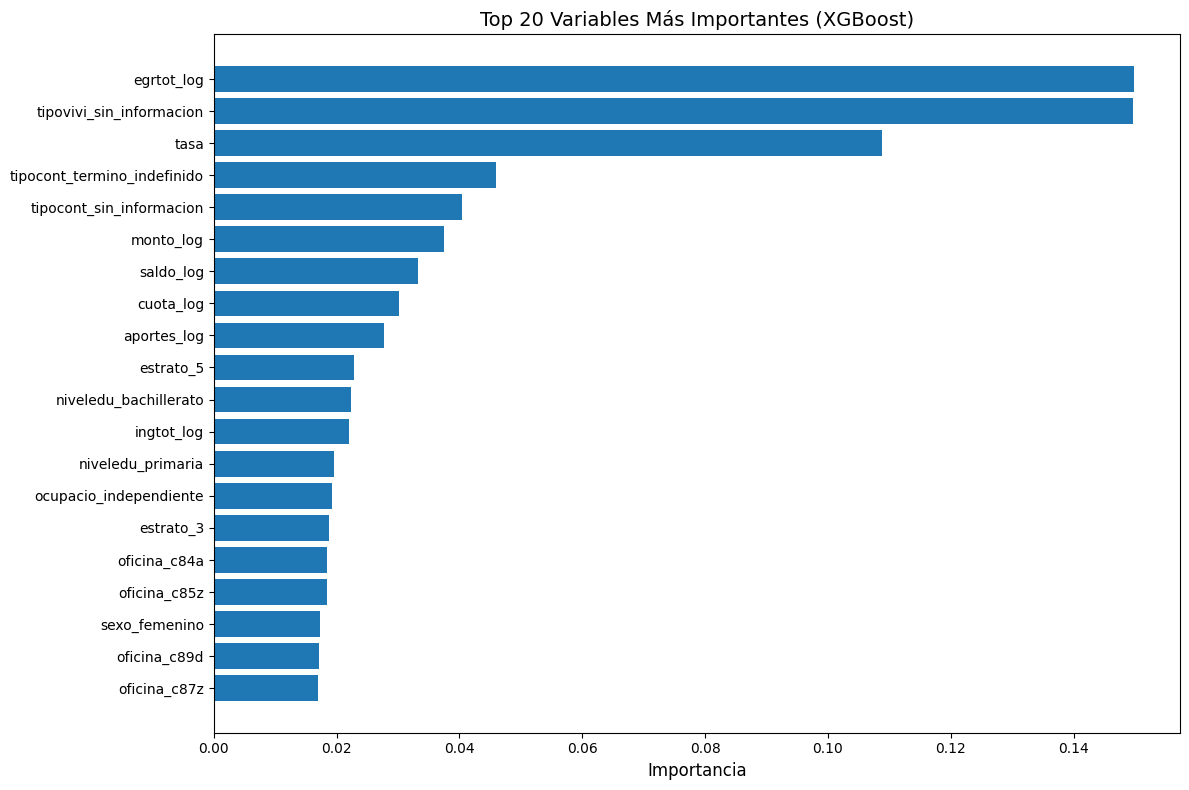

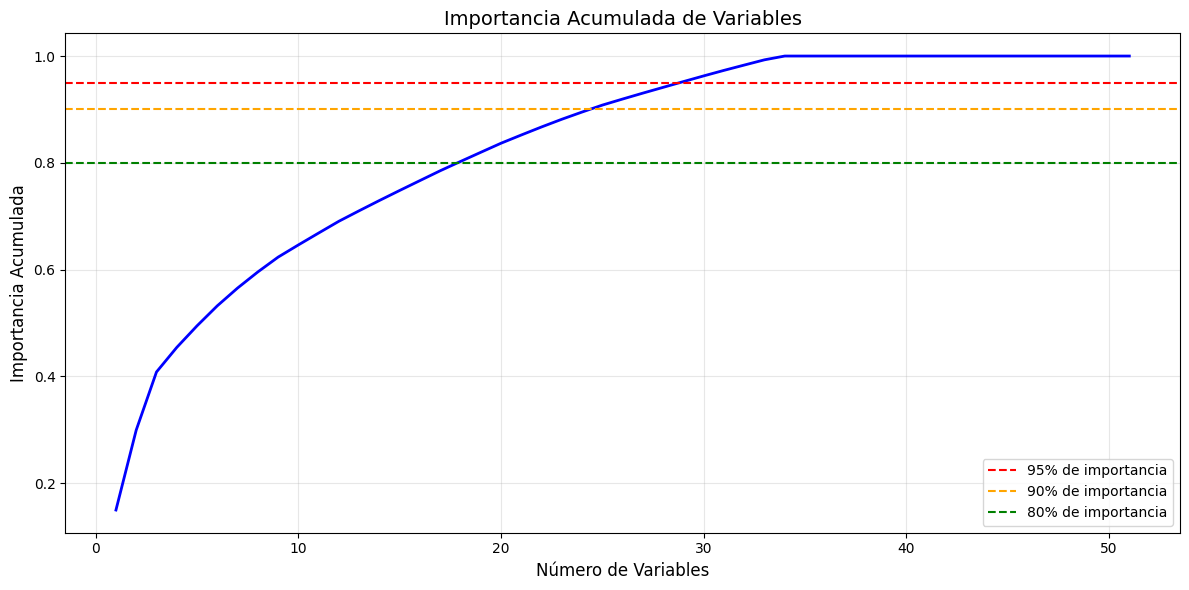


PASO 2: SELECCIÓN DE VARIABLES

✓ Variables para 95% de importancia: 29
✓ Variables con importancia > 0.01: 31
✓ Top 20 variables: 20

✓ Variables seleccionadas para el modelo final: 20

Variables seleccionadas:
   1. egrtot_log                               (imp: 0.1498)
   2. tipovivi_sin_informacion                 (imp: 0.1497)
   3. tasa                                     (imp: 0.1088)
   4. tipocont_termino_indefinido              (imp: 0.0460)
   5. tipocont_sin_informacion                 (imp: 0.0404)
   6. monto_log                                (imp: 0.0375)
   7. saldo_log                                (imp: 0.0333)
   8. cuota_log                                (imp: 0.0302)
   9. aportes_log                              (imp: 0.0277)
  10. estrato_5                                (imp: 0.0228)
  11. niveledu_bachillerato                    (imp: 0.0223)
  12. ingtot_log                               (imp: 0.0221)
  13. niveledu_primaria                        (imp: 0.

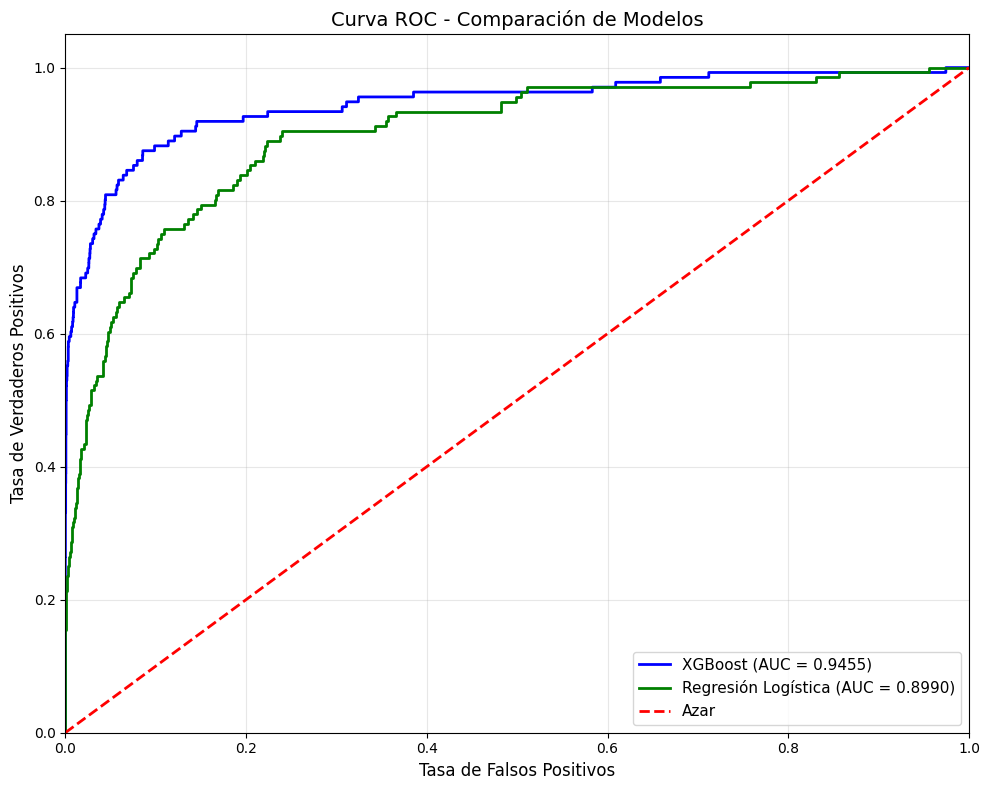

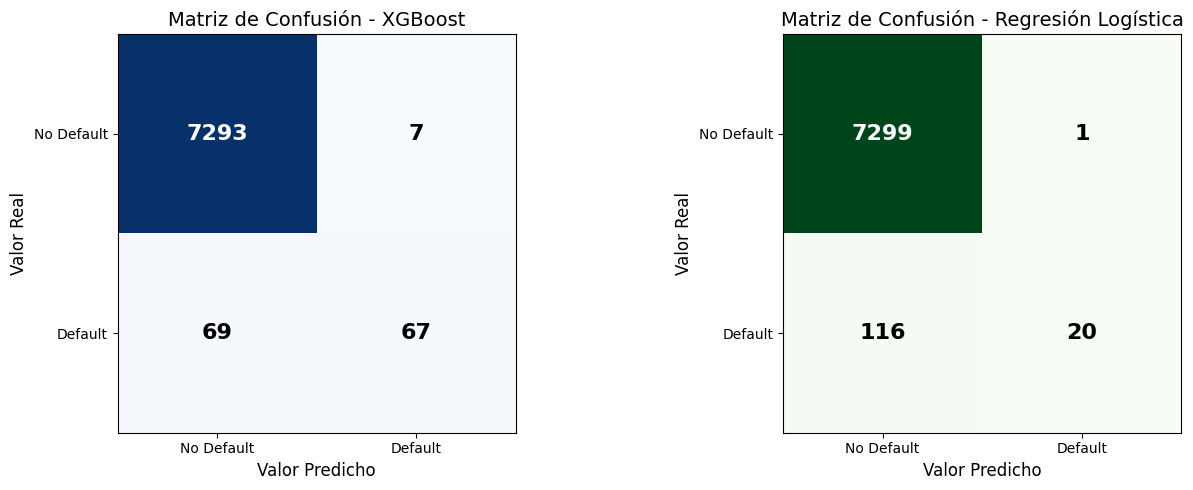


📊 COEFICIENTES DEL MODELO LOGÍSTICO:
                   variable  coeficiente  odds_ratio  importancia_xgb
                       tasa     6.270930  528.969174         0.108825
                  monto_log    -1.638842    0.194205         0.037489
                  cuota_log     1.360600    3.898531         0.030168
                  estrato_5    -1.285315    0.276563         0.022848
   tipocont_sin_informacion     1.170500    3.223605         0.040426
   tipovivi_sin_informacion     1.125301    3.081143         0.149683
          niveledu_primaria    -0.978438    0.375898         0.019642
               oficina_c85z     0.442034    1.555868         0.018410
      niveledu_bachillerato     0.436765    1.547692         0.022289
tipocont_termino_indefinido     0.435784    1.546174         0.045968
                  saldo_log     0.378609    1.460252         0.033259
               oficina_c84a    -0.246417    0.781596         0.018500
     ocupacio_independiente     0.165978    1.180547

In [38]:

# 1. Separar X y y
X = tabla_1AF.drop('default_dicotomic', axis=1)
y = tabla_1AF['default_dicotomic']

# 2. Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("="*60)
print("PASO 1: ENTRENAR XGBOOST")
print("="*60)
print(f"Variables iniciales: {X_train.shape[1]}")

# 3. Entrenar XGBoost
modelo_xgb = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='auc',
    use_label_encoder=False
)

modelo_xgb.fit(X_train, y_train)

# Predicciones XGBoost
y_pred_train_xgb = modelo_xgb.predict(X_train)
y_pred_test_xgb = modelo_xgb.predict(X_test)
y_pred_proba_train_xgb = modelo_xgb.predict_proba(X_train)[:, 1]
y_pred_proba_test_xgb = modelo_xgb.predict_proba(X_test)[:, 1]

# Métricas XGBoost
roc_auc_train_xgb = roc_auc_score(y_train, y_pred_proba_train_xgb)
roc_auc_test_xgb = roc_auc_score(y_test, y_pred_proba_test_xgb)

print(f"\n✓ XGBoost entrenado exitosamente!")
print(f"\n📊 MÉTRICAS XGBOOST:")
print(f"  ROC AUC Train: {roc_auc_train_xgb:.4f}")
print(f"  ROC AUC Test:  {roc_auc_test_xgb:.4f}")

print("\n📋 Classification Report XGBoost (Test):")
print(classification_report(y_test, y_pred_test_xgb, target_names=['No Default', 'Default']))

cm_xgb = confusion_matrix(y_test, y_pred_test_xgb)
print("\n📋 Confusion Matrix XGBoost (Test):")
print(cm_xgb)
print(f"\nTrue Negatives:  {cm_xgb[0,0]:>5}")
print(f"False Positives: {cm_xgb[0,1]:>5}")
print(f"False Negatives: {cm_xgb[1,0]:>5}")
print(f"True Positives:  {cm_xgb[1,1]:>5}")

# Calcular curva ROC para XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_test_xgb)
roc_auc_xgb_curve = auc(fpr_xgb, tpr_xgb)

# 4. Obtener importancia de variables
importancias = modelo_xgb.feature_importances_
importancia_df = pd.DataFrame({
    'variable': X_train.columns,
    'importancia': importancias
}).sort_values('importancia', ascending=False)

print("\n📊 TOP 20 VARIABLES MÁS IMPORTANTES:")
print(importancia_df.head(20).to_string(index=False))

# 5. Visualizar importancia de variables
plt.figure(figsize=(12, 8))
top_n = 20
importancia_top = importancia_df.head(top_n)
plt.barh(range(top_n), importancia_top['importancia'].values)
plt.yticks(range(top_n), importancia_top['variable'].values)
plt.xlabel('Importancia', fontsize=12)
plt.title(f'Top {top_n} Variables Más Importantes (XGBoost)', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 6. Gráfico de importancia acumulada
plt.figure(figsize=(12, 6))
importancia_acumulada = np.cumsum(importancia_df['importancia'].values)
plt.plot(range(1, len(importancia_acumulada) + 1), importancia_acumulada, 'b-', linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% de importancia')
plt.axhline(y=0.90, color='orange', linestyle='--', label='90% de importancia')
plt.axhline(y=0.80, color='g', linestyle='--', label='80% de importancia')
plt.xlabel('Número de Variables', fontsize=12)
plt.ylabel('Importancia Acumulada', fontsize=12)
plt.title('Importancia Acumulada de Variables', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7. SELECCIÓN DE VARIABLES - Diferentes criterios
print("\n" + "="*60)
print("PASO 2: SELECCIÓN DE VARIABLES")
print("="*60)

# Opción 1: Por umbral de importancia acumulada (ej: 95%)
umbral_acumulado = 0.95
importancia_acum = 0
variables_seleccionadas_95 = []
for _, row in importancia_df.iterrows():
    variables_seleccionadas_95.append(row['variable'])
    importancia_acum += row['importancia']
    if importancia_acum >= umbral_acumulado:
        break

print(f"\n✓ Variables para 95% de importancia: {len(variables_seleccionadas_95)}")

# Opción 2: Por umbral de importancia mínima
umbral_importancia = 0.01  # Variables con importancia > 1%
variables_seleccionadas_umbral = importancia_df[
    importancia_df['importancia'] > umbral_importancia
]['variable'].tolist()

print(f"✓ Variables con importancia > {umbral_importancia}: {len(variables_seleccionadas_umbral)}")

# Opción 3: Top N variables
top_n_vars = 20
variables_seleccionadas_top = importancia_df.head(top_n_vars)['variable'].tolist()

print(f"✓ Top {top_n_vars} variables: {len(variables_seleccionadas_top)}")

# 8. ELEGIR UNA OPCIÓN (puedes cambiar aquí)
variables_seleccionadas = variables_seleccionadas_top  # Cambia esto según prefieras

print(f"\n✓ Variables seleccionadas para el modelo final: {len(variables_seleccionadas)}")
print("\nVariables seleccionadas:")
for i, var in enumerate(variables_seleccionadas, 1):
    imp = importancia_df[importancia_df['variable'] == var]['importancia'].values[0]
    print(f"  {i:2d}. {var:40s} (imp: {imp:.4f})")

# 9. Crear datasets con variables seleccionadas
X_train_selected = X_train[variables_seleccionadas]
X_test_selected = X_test[variables_seleccionadas]

print("\n" + "="*60)
print("PASO 3: MODELO DE REGRESIÓN LOGÍSTICA FINAL")
print("="*60)
print(f"Reducción: {X_train.shape[1]} → {X_train_selected.shape[1]} variables")

# 10. Entrenar Regresión Logística con variables seleccionadas
modelo_logit = LogisticRegression(max_iter=1000, random_state=42)
modelo_logit.fit(X_train_selected, y_train)

# 11. Predicciones
y_pred_train_logit = modelo_logit.predict(X_train_selected)
y_pred_test_logit = modelo_logit.predict(X_test_selected)
y_pred_proba_train_logit = modelo_logit.predict_proba(X_train_selected)[:, 1]
y_pred_proba_test_logit = modelo_logit.predict_proba(X_test_selected)[:, 1]

# 12. Evaluación
roc_auc_train_logit = roc_auc_score(y_train, y_pred_proba_train_logit)
roc_auc_test_logit = roc_auc_score(y_test, y_pred_proba_test_logit)

# Calcular curva ROC para Logistic Regression
fpr_logit, tpr_logit, _ = roc_curve(y_test, y_pred_proba_test_logit)
roc_auc_logit_curve = auc(fpr_logit, tpr_logit)

print("\n" + "="*60)
print("COMPARACIÓN DE MODELOS")
print("="*60)

print(f"\n📊 XGBOOST (todas las variables - {X_train.shape[1]} vars):")
print(f"    ROC AUC Train: {roc_auc_train_xgb:.4f}")
print(f"    ROC AUC Test:  {roc_auc_test_xgb:.4f}")

print(f"\n📊 REGRESIÓN LOGÍSTICA (variables seleccionadas - {len(variables_seleccionadas)} vars):")
print(f"    ROC AUC Train: {roc_auc_train_logit:.4f}")
print(f"    ROC AUC Test:  {roc_auc_test_logit:.4f}")

# Diferencia de desempeño
diff_roc = roc_auc_test_xgb - roc_auc_test_logit
print(f"\n📉 Diferencia ROC AUC: {diff_roc:.4f} ({diff_roc*100:.2f}%)")
print(f"📊 Reducción de variables: {X_train.shape[1] - len(variables_seleccionadas)} ({(1-len(variables_seleccionadas)/X_train.shape[1])*100:.1f}%)")

print("\n📋 Classification Report (Regresión Logística - Test):")
print(classification_report(y_test, y_pred_test_logit, target_names=['No Default', 'Default']))

cm_logit = confusion_matrix(y_test, y_pred_test_logit)
print("\n📋 Confusion Matrix (Regresión Logística - Test):")
print(cm_logit)
print(f"\nTrue Negatives:  {cm_logit[0,0]:>5}")
print(f"False Positives: {cm_logit[0,1]:>5}")
print(f"False Negatives: {cm_logit[1,0]:>5}")
print(f"True Positives:  {cm_logit[1,1]:>5}")

# 13. Visualización: Curva ROC comparativa
plt.figure(figsize=(10, 8))
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, 
         label=f'XGBoost (AUC = {roc_auc_xgb_curve:.4f})')
plt.plot(fpr_logit, tpr_logit, color='green', lw=2, 
         label=f'Regresión Logística (AUC = {roc_auc_logit_curve:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Azar')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.title('Curva ROC - Comparación de Modelos', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 14. Visualización: Matrices de confusión comparativas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de confusión XGBoost
im1 = axes[0].imshow(cm_xgb, interpolation='nearest', cmap=plt.cm.Blues)
axes[0].set_title('Matriz de Confusión - XGBoost', fontsize=14)
axes[0].set_ylabel('Valor Real', fontsize=12)
axes[0].set_xlabel('Valor Predicho', fontsize=12)
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['No Default', 'Default'])
axes[0].set_yticklabels(['No Default', 'Default'])

# Agregar valores en la matriz
for i in range(2):
    for j in range(2):
        text = axes[0].text(j, i, cm_xgb[i, j],
                           ha="center", va="center", color="white" if cm_xgb[i, j] > cm_xgb.max()/2 else "black",
                           fontsize=16, weight='bold')

# Matriz de confusión Regresión Logística
im2 = axes[1].imshow(cm_logit, interpolation='nearest', cmap=plt.cm.Greens)
axes[1].set_title('Matriz de Confusión - Regresión Logística', fontsize=14)
axes[1].set_ylabel('Valor Real', fontsize=12)
axes[1].set_xlabel('Valor Predicho', fontsize=12)
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['No Default', 'Default'])
axes[1].set_yticklabels(['No Default', 'Default'])

# Agregar valores en la matriz
for i in range(2):
    for j in range(2):
        text = axes[1].text(j, i, cm_logit[i, j],
                           ha="center", va="center", color="white" if cm_logit[i, j] > cm_logit.max()/2 else "black",
                           fontsize=16, weight='bold')

plt.tight_layout()
plt.show()

# 15. Coeficientes del modelo logístico
coeficientes = pd.DataFrame({
    'variable': variables_seleccionadas,
    'coeficiente': modelo_logit.coef_[0],
    'odds_ratio': np.exp(modelo_logit.coef_[0]),
    'importancia_xgb': [importancia_df[importancia_df['variable'] == var]['importancia'].values[0] 
                        for var in variables_seleccionadas]
}).sort_values('coeficiente', key=abs, ascending=False)

print("\n📊 COEFICIENTES DEL MODELO LOGÍSTICO:")
print(coeficientes.to_string(index=False))

print("\n" + "="*60)
print("RESUMEN FINAL")
print("="*60)
print(f"✓ XGBoost: {X_train.shape[1]} variables → ROC AUC = {roc_auc_test_xgb:.4f}")
print(f"✓ Regresión Logística: {len(variables_seleccionadas)} variables → ROC AUC = {roc_auc_test_logit:.4f}")
print(f"✓ Reducción de {X_train.shape[1] - len(variables_seleccionadas)} variables ({(1-len(variables_seleccionadas)/X_train.shape[1])*100:.1f}%)")
print(f"✓ Pérdida de desempeño: {diff_roc:.4f} ({diff_roc*100:.2f}%)")
print("\n✓ Proceso completado exitosamente!")

#### Calculo de tabla de tasa de malos:

ENTRENANDO XGBOOST CON 20 VARIABLES SELECCIONADAS
Variables en el modelo: 20
Train: 17,350 | Test: 7,436

✓ Modelo XGBoost entrenado exitosamente

📊 MÉTRICAS:
  ROC AUC Train: 0.9950
  ROC AUC Test:  0.9477

📋 Classification Report (Test):
              precision    recall  f1-score   support

  No Default       0.99      1.00      0.99      7300
     Default       0.89      0.49      0.63       136

    accuracy                           0.99      7436
   macro avg       0.94      0.74      0.81      7436
weighted avg       0.99      0.99      0.99      7436


📋 Confusion Matrix (Test):
[[7292    8]
 [  70   66]]

True Negatives:   7292
False Positives:     8
False Negatives:    70
True Positives:     66

IMPORTANCIA DE VARIABLES (XGBOOST)
                   variable  importancia
   tipovivi_sin_informacion     0.185429
                 egrtot_log     0.163199
                       tasa     0.136149
tipocont_termino_indefinido     0.054860
                  monto_log     0.047661
   

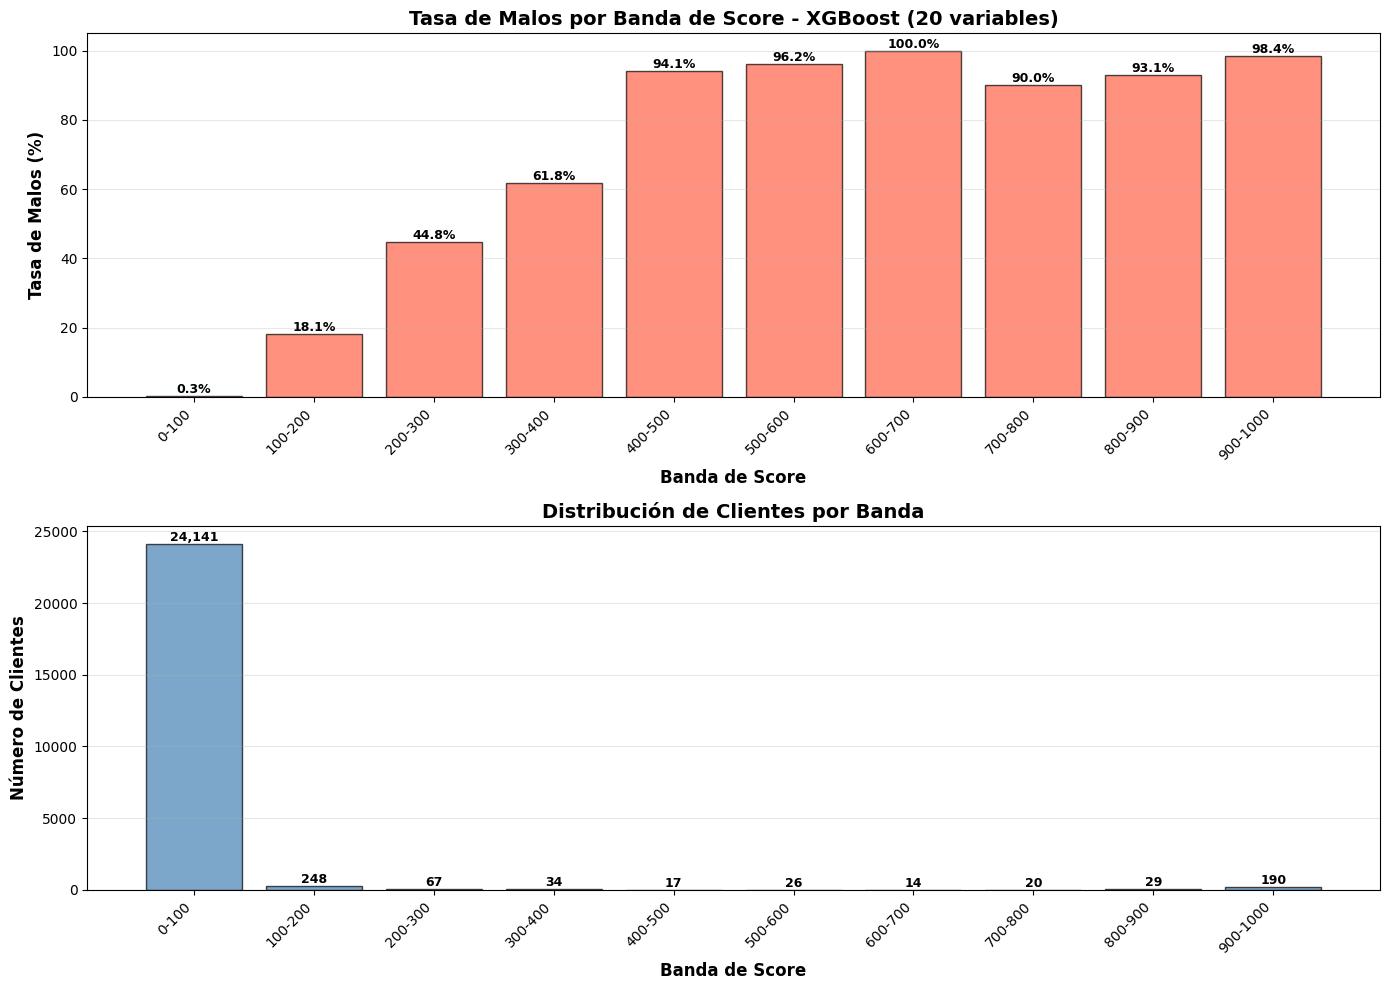


✓ Archivos exportados:
  • tabla_con_scores_xgboost_20vars.csv
  • tasas_malos_xgboost_20vars.xlsx
  • importancia_variables_xgboost.xlsx


In [43]:

# Variables seleccionadas (las 20 del modelo logístico)
variables_modelo = [
    'tasa', 'monto_log', 'cuota_log', 'estrato_5',
    'tipocont_sin_informacion', 'tipovivi_sin_informacion',
    'niveledu_primaria', 'oficina_c85z', 'niveledu_bachillerato',
    'tipocont_termino_indefinido', 'saldo_log', 'oficina_c84a',
    'ocupacio_independiente', 'oficina_c89d', 'egrtot_log',
    'aportes_log', 'sexo_femenino', 'oficina_c87z',
    'estrato_3', 'ingtot_log'
]

# 1. Preparar datos
print("="*60)
print("ENTRENANDO XGBOOST CON 20 VARIABLES SELECCIONADAS")
print("="*60)

X = tabla_1AF[variables_modelo]
y = tabla_1AF['default_dicotomic']

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Variables en el modelo: {len(variables_modelo)}")
print(f"Train: {X_train.shape[0]:,} | Test: {X_test.shape[0]:,}")

# 2. Entrenar XGBoost
modelo_xgb = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='auc'
)

modelo_xgb.fit(X_train, y_train)

# 3. Evaluar en train y test
y_pred_train = modelo_xgb.predict(X_train)
y_pred_test = modelo_xgb.predict(X_test)
y_pred_proba_train = modelo_xgb.predict_proba(X_train)[:, 1]
y_pred_proba_test = modelo_xgb.predict_proba(X_test)[:, 1]

roc_auc_train = roc_auc_score(y_train, y_pred_proba_train)
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)

print(f"\n✓ Modelo XGBoost entrenado exitosamente")
print(f"\n📊 MÉTRICAS:")
print(f"  ROC AUC Train: {roc_auc_train:.4f}")
print(f"  ROC AUC Test:  {roc_auc_test:.4f}")

print("\n📋 Classification Report (Test):")
print(classification_report(y_test, y_pred_test, target_names=['No Default', 'Default']))

cm = confusion_matrix(y_test, y_pred_test)
print("\n📋 Confusion Matrix (Test):")
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]:>5}")
print(f"False Positives: {cm[0,1]:>5}")
print(f"False Negatives: {cm[1,0]:>5}")
print(f"True Positives:  {cm[1,1]:>5}")

# 4. Importancia de variables
print("\n" + "="*60)
print("IMPORTANCIA DE VARIABLES (XGBOOST)")
print("="*60)

importancias = modelo_xgb.feature_importances_
importancia_df = pd.DataFrame({
    'variable': variables_modelo,
    'importancia': importancias
}).sort_values('importancia', ascending=False)

print(importancia_df.to_string(index=False))

# 5. Predecir en TODA la tabla
print("\n" + "="*60)
print("PREDICIENDO EN TODA LA TABLA")
print("="*60)

X_toda_tabla = tabla_1AF[variables_modelo]
probabilidad_default = modelo_xgb.predict_proba(X_toda_tabla)[:, 1]

tabla_1AF['probabilidad_default_xgb'] = probabilidad_default
tabla_1AF['score_xgb'] = (probabilidad_default * 1000).astype(int)

print(f"✓ Probabilidades calculadas para {len(tabla_1AF):,} registros")
print(f"  Probabilidad promedio: {probabilidad_default.mean():.2%}")
print(f"  Score promedio: {tabla_1AF['score_xgb'].mean():.0f}")
print(f"  Score mínimo: {tabla_1AF['score_xgb'].min()}")
print(f"  Score máximo: {tabla_1AF['score_xgb'].max()}")

# 6. Crear bandas de score cada 100 puntos
tabla_1AF['banda_score_xgb'] = pd.cut(
    tabla_1AF['score_xgb'],
    bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    labels=['0-100', '100-200', '200-300', '300-400', '400-500', 
            '500-600', '600-700', '700-800', '800-900', '900-1000'],
    include_lowest=True
)

# 7. Calcular tabla de tasas de malos por banda
tabla_tasas_xgb = tabla_1AF.groupby('banda_score_xgb', observed=True).agg(
    total_clientes=('default_dicotomic', 'count'),
    malos=('default_dicotomic', 'sum'),
    buenos=('default_dicotomic', lambda x: (x == 0).sum()),
    tasa_malos=('default_dicotomic', 'mean'),
    score_promedio=('score_xgb', 'mean'),
    score_min=('score_xgb', 'min'),
    score_max=('score_xgb', 'max')
).reset_index()

# Calcular porcentajes
tabla_tasas_xgb['%_clientes'] = (tabla_tasas_xgb['total_clientes'] / tabla_tasas_xgb['total_clientes'].sum() * 100)
tabla_tasas_xgb['tasa_malos_%'] = tabla_tasas_xgb['tasa_malos'] * 100

# Reordenar columnas
tabla_tasas_xgb = tabla_tasas_xgb[[
    'banda_score_xgb', 'total_clientes', '%_clientes', 'buenos', 'malos', 
    'tasa_malos_%', 'score_promedio', 'score_min', 'score_max'
]]

# 8. Mostrar tabla de resultados
print("\n" + "="*90)
print("TABLA DE TASAS DE MALOS POR BANDA DE SCORE (XGBOOST - 20 VARIABLES)")
print("="*90)
print(tabla_tasas_xgb.to_string(index=False))

# 9. Resumen global
print("\n" + "="*90)
print("RESUMEN GLOBAL")
print("="*90)
print(f"Total Clientes: {len(tabla_1AF):,}")
print(f"Total Buenos: {(tabla_1AF['default_dicotomic'] == 0).sum():,} ({(tabla_1AF['default_dicotomic'] == 0).sum()/len(tabla_1AF)*100:.1f}%)")
print(f"Total Malos: {tabla_1AF['default_dicotomic'].sum():,} ({tabla_1AF['default_dicotomic'].sum()/len(tabla_1AF)*100:.1f}%)")
print(f"Tasa de Malos Global: {tabla_1AF['default_dicotomic'].mean()*100:.2f}%")

# 10. Análisis por nivel de riesgo
print("\n" + "="*90)
print("ANÁLISIS POR NIVEL DE RIESGO")
print("="*90)

alto_riesgo = tabla_tasas_xgb[tabla_tasas_xgb['tasa_malos_%'] >= 30]
medio_riesgo = tabla_tasas_xgb[(tabla_tasas_xgb['tasa_malos_%'] >= 15) & (tabla_tasas_xgb['tasa_malos_%'] < 30)]
bajo_riesgo = tabla_tasas_xgb[tabla_tasas_xgb['tasa_malos_%'] < 15]

if len(alto_riesgo) > 0:
    print(f"\n🔴 ALTO RIESGO (≥30% malos): {len(alto_riesgo)} bandas")
    print(f"   Total clientes: {alto_riesgo['total_clientes'].sum():,} ({alto_riesgo['%_clientes'].sum():.1f}%)")
    for _, row in alto_riesgo.iterrows():
        print(f"   • {row['banda_score_xgb']}: {row['tasa_malos_%']:.1f}% malos | {int(row['total_clientes']):,} clientes | Score promedio: {row['score_promedio']:.0f}")

if len(medio_riesgo) > 0:
    print(f"\n🟡 MEDIO RIESGO (15-30% malos): {len(medio_riesgo)} bandas")
    print(f"   Total clientes: {medio_riesgo['total_clientes'].sum():,} ({medio_riesgo['%_clientes'].sum():.1f}%)")
    for _, row in medio_riesgo.iterrows():
        print(f"   • {row['banda_score_xgb']}: {row['tasa_malos_%']:.1f}% malos | {int(row['total_clientes']):,} clientes | Score promedio: {row['score_promedio']:.0f}")

if len(bajo_riesgo) > 0:
    print(f"\n🟢 BAJO RIESGO (<15% malos): {len(bajo_riesgo)} bandas")
    print(f"   Total clientes: {bajo_riesgo['total_clientes'].sum():,} ({bajo_riesgo['%_clientes'].sum():.1f}%)")
    for _, row in bajo_riesgo.iterrows():
        print(f"   • {row['banda_score_xgb']}: {row['tasa_malos_%']:.1f}% malos | {int(row['total_clientes']):,} clientes | Score promedio: {row['score_promedio']:.0f}")

# 11. Métricas de discriminación
print("\n" + "="*90)
print("PODER DE DISCRIMINACIÓN DEL MODELO")
print("="*90)

# KS
def calcular_ks(y_true, y_pred_proba):
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred_proba})
    df = df.sort_values('y_pred', ascending=False).reset_index(drop=True)
    df['malos_acum'] = df['y_true'].cumsum() / df['y_true'].sum()
    df['buenos_acum'] = (1 - df['y_true']).cumsum() / (1 - df['y_true']).sum()
    df['ks'] = abs(df['malos_acum'] - df['buenos_acum'])
    return df['ks'].max()

roc_auc_total = roc_auc_score(y, probabilidad_default)
ks_value = calcular_ks(y.values, probabilidad_default)
gini = 2 * roc_auc_total - 1

print(f"ROC AUC (toda la tabla): {roc_auc_total:.4f}")
print(f"Kolmogorov-Smirnov (KS): {ks_value:.4f}")
print(f"Coeficiente de Gini: {gini:.4f}")

print("\nInterpretación:")
if roc_auc_total > 0.8:
    print(f"  ✓ ROC AUC {roc_auc_total:.4f} - Excelente")
elif roc_auc_total > 0.7:
    print(f"  ✓ ROC AUC {roc_auc_total:.4f} - Bueno")
else:
    print(f"  ⚠ ROC AUC {roc_auc_total:.4f} - Aceptable")

if ks_value > 0.4:
    print(f"  ✓ KS {ks_value:.4f} - Excelente discriminación")
elif ks_value > 0.3:
    print(f"  ✓ KS {ks_value:.4f} - Buena discriminación")
else:
    print(f"  ⚠ KS {ks_value:.4f} - Discriminación aceptable")

if gini > 0.6:
    print(f"  ✓ Gini {gini:.4f} - Excelente modelo")
elif gini > 0.4:
    print(f"  ✓ Gini {gini:.4f} - Buen modelo")
else:
    print(f"  ⚠ Gini {gini:.4f} - Modelo aceptable")

# 12. Gráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Gráfico 1: Tasa de malos
x_pos = np.arange(len(tabla_tasas_xgb))
bars1 = ax1.bar(x_pos, tabla_tasas_xgb['tasa_malos_%'], color='tomato', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Banda de Score', fontsize=12, fontweight='bold')
ax1.set_ylabel('Tasa de Malos (%)', fontsize=12, fontweight='bold')
ax1.set_title('Tasa de Malos por Banda de Score - XGBoost (20 variables)', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(tabla_tasas_xgb['banda_score_xgb'], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

for bar, valor in zip(bars1, tabla_tasas_xgb['tasa_malos_%']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{valor:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Gráfico 2: Distribución
bars2 = ax2.bar(x_pos, tabla_tasas_xgb['total_clientes'], color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Banda de Score', fontsize=12, fontweight='bold')
ax2.set_ylabel('Número de Clientes', fontsize=12, fontweight='bold')
ax2.set_title('Distribución de Clientes por Banda', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(tabla_tasas_xgb['banda_score_xgb'], rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

for bar, valor in zip(bars2, tabla_tasas_xgb['total_clientes']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(valor):,}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# 13. Exportar resultados
tabla_1AF.to_csv('tabla_con_scores_xgboost_20vars.csv', index=False)

print("\n" + "="*90)
print("✓ Archivos exportados:")
print("  • tabla_con_scores_xgboost_20vars.csv")
print("  • tasas_malos_xgboost_20vars.xlsx")
print("  • importancia_variables_xgboost.xlsx")
print("="*90)

#### Calculo Punto de corte optimo para aprobar o rechazar credito:

CÁLCULO DEL PUNTO DE CORTE ÓPTIMO

📊 MÉTODO 1: ÍNDICE DE YOUDEN
--------------------------------------------------------------------------------
Punto de corte óptimo (Youden): 0.0117 (1.17%)
Sensibilidad (Recall): 0.9265
Especificidad: 0.8763
Índice de Youden: 0.8028

📊 MÉTODO 2: DISTANCIA AL PUNTO PERFECTO
--------------------------------------------------------------------------------
Punto de corte óptimo (Distancia): 0.0148 (1.48%)
Sensibilidad: 0.9044
Especificidad: 0.8953

📊 MÉTODO 3: F1-SCORE MÁXIMO
--------------------------------------------------------------------------------
Punto de corte óptimo (F1): 0.2259 (22.59%)
Precision: 0.7692
Recall: 0.5882
F1-Score: 0.6667

📊 MÉTODO 4: ANÁLISIS COSTO-BENEFICIO
--------------------------------------------------------------------------------
Costos configurados:
  • Costo de aprobar un malo (FN): $100
  • Costo de rechazar un bueno (FP): $10
  • Beneficio de rechazar un malo (TN): $5
  • Beneficio de aprobar un bueno (TP): $20

Pun

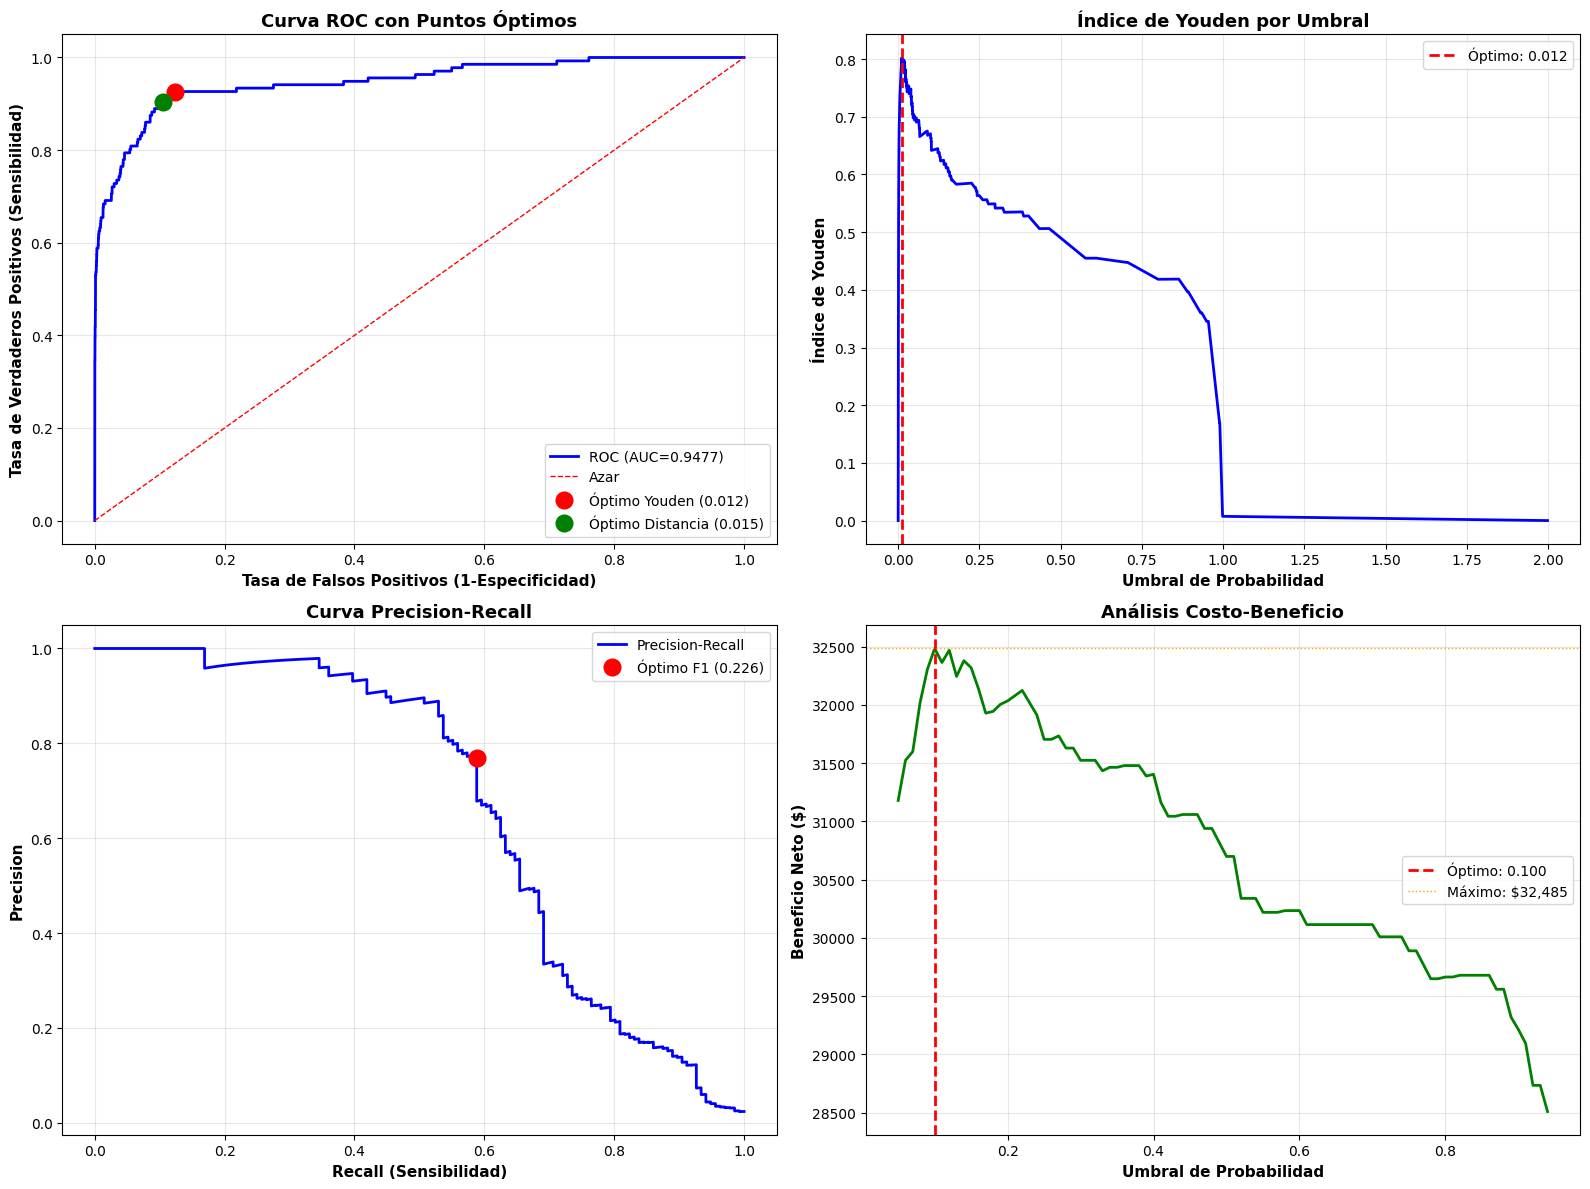


ANÁLISIS DE SENSIBILIDAD - DIFERENTES UMBRALES
Umbral  Score Tasa_Aprob_% Precision Recall  TP  FP  FN   TN
 0.100    100          1.8     0.487  0.676  92  97  44 7203
 0.150    150          1.8     0.656  0.618  84  44  52 7256
 0.200    200          1.8     0.721  0.588  80  31  56 7269
 0.100    100          1.8     0.487  0.676  92  97  44 7203
 0.300    300          1.8     0.813  0.544  74  17  62 7283
 0.350    350          1.8     0.849  0.537  73  13  63 7287
 0.400    400          1.8     0.889  0.529  72   9  64 7291

✓ Análisis completado


In [44]:

print("="*80)
print("CÁLCULO DEL PUNTO DE CORTE ÓPTIMO")
print("="*80)

# Usar las predicciones del test set
y_true = y_test.values
y_pred_proba = y_pred_proba_test

# 1. MÉTODO 1: Maximizar el Índice de Youden (Sensibilidad + Especificidad - 1)
print("\n📊 MÉTODO 1: ÍNDICE DE YOUDEN")
print("-"*80)

fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_proba)
youden_index = tpr - fpr
optimal_idx_youden = np.argmax(youden_index)
optimal_threshold_youden = thresholds_roc[optimal_idx_youden]

print(f"Punto de corte óptimo (Youden): {optimal_threshold_youden:.4f} ({optimal_threshold_youden*100:.2f}%)")
print(f"Sensibilidad (Recall): {tpr[optimal_idx_youden]:.4f}")
print(f"Especificidad: {1-fpr[optimal_idx_youden]:.4f}")
print(f"Índice de Youden: {youden_index[optimal_idx_youden]:.4f}")

# 2. MÉTODO 2: Minimizar distancia a punto perfecto (0,1)
print("\n📊 MÉTODO 2: DISTANCIA AL PUNTO PERFECTO")
print("-"*80)

distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)
optimal_idx_distance = np.argmin(distances)
optimal_threshold_distance = thresholds_roc[optimal_idx_distance]

print(f"Punto de corte óptimo (Distancia): {optimal_threshold_distance:.4f} ({optimal_threshold_distance*100:.2f}%)")
print(f"Sensibilidad: {tpr[optimal_idx_distance]:.4f}")
print(f"Especificidad: {1-fpr[optimal_idx_distance]:.4f}")

# 3. MÉTODO 3: Maximizar F1-Score
print("\n📊 MÉTODO 3: F1-SCORE MÁXIMO")
print("-"*80)

precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx_f1 = np.argmax(f1_scores)
optimal_threshold_f1 = thresholds_pr[optimal_idx_f1]

print(f"Punto de corte óptimo (F1): {optimal_threshold_f1:.4f} ({optimal_threshold_f1*100:.2f}%)")
print(f"Precision: {precision[optimal_idx_f1]:.4f}")
print(f"Recall: {recall[optimal_idx_f1]:.4f}")
print(f"F1-Score: {f1_scores[optimal_idx_f1]:.4f}")

# 4. MÉTODO 4: Análisis de Costo-Beneficio (personalizable)
print("\n📊 MÉTODO 4: ANÁLISIS COSTO-BENEFICIO")
print("-"*80)

# Definir costos (AJUSTA ESTOS VALORES SEGÚN TU NEGOCIO)
costo_fn = 100  # Costo de aprobar un malo (pérdida por default)
costo_fp = 10   # Costo de rechazar un bueno (pérdida de oportunidad)
beneficio_tn = 5  # Beneficio de rechazar correctamente un malo
beneficio_tp = 20 # Beneficio de aprobar correctamente un bueno

print(f"Costos configurados:")
print(f"  • Costo de aprobar un malo (FN): ${costo_fn}")
print(f"  • Costo de rechazar un bueno (FP): ${costo_fp}")
print(f"  • Beneficio de rechazar un malo (TN): ${beneficio_tn}")
print(f"  • Beneficio de aprobar un bueno (TP): ${beneficio_tp}")

# Calcular beneficio neto para diferentes umbrales
umbrales_analisis = np.arange(0.05, 0.95, 0.01)
beneficios_netos = []

for umbral in umbrales_analisis:
    y_pred_temp = (y_pred_proba >= umbral).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_temp).ravel()
    
    beneficio_neto = (tp * beneficio_tp) + (tn * beneficio_tn) - (fp * costo_fp) - (fn * costo_fn)
    beneficios_netos.append(beneficio_neto)

optimal_idx_costo = np.argmax(beneficios_netos)
optimal_threshold_costo = umbrales_analisis[optimal_idx_costo]
beneficio_maximo = beneficios_netos[optimal_idx_costo]

y_pred_costo = (y_pred_proba >= optimal_threshold_costo).astype(int)
tn_opt, fp_opt, fn_opt, tp_opt = confusion_matrix(y_true, y_pred_costo).ravel()

print(f"\nPunto de corte óptimo (Costo-Beneficio): {optimal_threshold_costo:.4f} ({optimal_threshold_costo*100:.2f}%)")
print(f"Beneficio neto máximo: ${beneficio_maximo:,.2f}")
print(f"Matriz de confusión:")
print(f"  TN (rechazar malo): {tn_opt:,} | FP (rechazar bueno): {fp_opt:,}")
print(f"  FN (aprobar malo): {fn_opt:,} | TP (aprobar bueno): {tp_opt:,}")

# 5. RESUMEN Y COMPARACIÓN DE MÉTODOS
print("\n" + "="*80)
print("RESUMEN DE PUNTOS DE CORTE ÓPTIMOS")
print("="*80)

metodos_comparacion = pd.DataFrame({
    'Método': ['Youden', 'Distancia', 'F1-Score', 'Costo-Beneficio'],
    'Umbral': [optimal_threshold_youden, optimal_threshold_distance, 
               optimal_threshold_f1, optimal_threshold_costo],
    'Umbral_%': [optimal_threshold_youden*100, optimal_threshold_distance*100, 
                 optimal_threshold_f1*100, optimal_threshold_costo*100]
})

print(metodos_comparacion.to_string(index=False))

# 6. ANÁLISIS DETALLADO DEL PUNTO DE CORTE RECOMENDADO
print("\n" + "="*80)
print("RECOMENDACIÓN: MÉTODO COSTO-BENEFICIO")
print("="*80)

umbral_recomendado = optimal_threshold_costo
score_recomendado = int(umbral_recomendado * 1000)

print(f"\n🎯 PUNTO DE CORTE RECOMENDADO:")
print(f"   Probabilidad: {umbral_recomendado:.4f} ({umbral_recomendado*100:.2f}%)")
print(f"   Score: {score_recomendado}")

y_pred_final = (y_pred_proba >= umbral_recomendado).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_final).ravel()

total = tn + fp + fn + tp
tasa_aprobacion = (tp + fn) / total * 100
tasa_rechazo = (tn + fp) / total * 100
tasa_acierto_global = (tp + tn) / total * 100

print(f"\n📊 MÉTRICAS CON ESTE UMBRAL:")
print(f"   • Tasa de Aprobación: {tasa_aprobacion:.2f}%")
print(f"   • Tasa de Rechazo: {tasa_rechazo:.2f}%")
print(f"   • Exactitud Global: {tasa_acierto_global:.2f}%")
print(f"   • Sensibilidad (detectar malos): {tp/(tp+fn):.2%}")
print(f"   • Especificidad (detectar buenos): {tn/(tn+fp):.2%}")
print(f"   • Precisión (buenos aprobados): {tp/(tp+fp):.2%}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
print(f"   {'':20} Predicho NO Default | Predicho Default")
print(f"   Real NO Default:    {tn:8,} (TN)    |  {fp:8,} (FP)")
print(f"   Real Default:       {fn:8,} (FN)    |  {tp:8,} (TP)")

print(f"\n💰 IMPACTO FINANCIERO:")
ingresos = (tp * beneficio_tp) + (tn * beneficio_tn)
costos = (fp * costo_fp) + (fn * costo_fn)
beneficio_neto_total = ingresos - costos

print(f"   • Ingresos totales: ${ingresos:,.2f}")
print(f"   • Costos totales: ${costos:,.2f}")
print(f"   • Beneficio neto: ${beneficio_neto_total:,.2f}")

# 7. POLÍTICA DE APROBACIÓN/RECHAZO
print("\n" + "="*80)
print("POLÍTICA DE APROBACIÓN/RECHAZO RECOMENDADA")
print("="*80)

print(f"\n✅ APROBAR si:")
print(f"   • Probabilidad de default < {umbral_recomendado:.4f} ({umbral_recomendado*100:.2f}%)")
print(f"   • Score < {score_recomendado}")

print(f"\n❌ RECHAZAR si:")
print(f"   • Probabilidad de default ≥ {umbral_recomendado:.4f} ({umbral_recomendado*100:.2f}%)")
print(f"   • Score ≥ {score_recomendado}")

print(f"\n⚠️ ZONA GRIS (opcional - requiere análisis manual):")
zona_gris_inferior = umbral_recomendado - 0.05
zona_gris_superior = umbral_recomendado + 0.05
print(f"   • Probabilidad entre {zona_gris_inferior:.4f} y {zona_gris_superior:.4f}")
print(f"   • Score entre {int(zona_gris_inferior*1000)} y {int(zona_gris_superior*1000)}")

# 8. VISUALIZACIONES
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Curva ROC con punto óptimo
axes[0, 0].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC={roc_auc_test:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'r--', linewidth=1, label='Azar')
axes[0, 0].plot(fpr[optimal_idx_youden], tpr[optimal_idx_youden], 'ro', markersize=12, 
                label=f'Óptimo Youden ({optimal_threshold_youden:.3f})')
axes[0, 0].plot(fpr[optimal_idx_distance], tpr[optimal_idx_distance], 'go', markersize=12,
                label=f'Óptimo Distancia ({optimal_threshold_distance:.3f})')
axes[0, 0].set_xlabel('Tasa de Falsos Positivos (1-Especificidad)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Curva ROC con Puntos Óptimos', fontsize=13, fontweight='bold')
axes[0, 0].legend(loc='lower right')
axes[0, 0].grid(alpha=0.3)

# Gráfico 2: Índice de Youden vs Umbral
axes[0, 1].plot(thresholds_roc, youden_index, 'b-', linewidth=2)
axes[0, 1].axvline(optimal_threshold_youden, color='r', linestyle='--', linewidth=2,
                   label=f'Óptimo: {optimal_threshold_youden:.3f}')
axes[0, 1].set_xlabel('Umbral de Probabilidad', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Índice de Youden', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Índice de Youden por Umbral', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Gráfico 3: Curva Precision-Recall con F1
axes[1, 0].plot(recall, precision, 'b-', linewidth=2, label='Precision-Recall')
axes[1, 0].plot(recall[optimal_idx_f1], precision[optimal_idx_f1], 'ro', markersize=12,
                label=f'Óptimo F1 ({optimal_threshold_f1:.3f})')
axes[1, 0].set_xlabel('Recall (Sensibilidad)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Precision', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Curva Precision-Recall', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Gráfico 4: Beneficio Neto vs Umbral
axes[1, 1].plot(umbrales_analisis, beneficios_netos, 'g-', linewidth=2)
axes[1, 1].axvline(optimal_threshold_costo, color='r', linestyle='--', linewidth=2,
                   label=f'Óptimo: {optimal_threshold_costo:.3f}')
axes[1, 1].axhline(beneficio_maximo, color='orange', linestyle=':', linewidth=1,
                   label=f'Máximo: ${beneficio_maximo:,.0f}')
axes[1, 1].set_xlabel('Umbral de Probabilidad', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Beneficio Neto ($)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Análisis Costo-Beneficio', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 9. Tabla con diferentes umbrales
print("\n" + "="*80)
print("ANÁLISIS DE SENSIBILIDAD - DIFERENTES UMBRALES")
print("="*80)

umbrales_analizar = [0.10, 0.15, 0.20, umbral_recomendado, 0.30, 0.35, 0.40]
resultados_umbrales = []

for umbral in umbrales_analizar:
    y_pred_temp = (y_pred_proba >= umbral).astype(int)
    tn_t, fp_t, fn_t, tp_t = confusion_matrix(y_true, y_pred_temp).ravel()
    
    tasa_aprob = (tp_t + fn_t) / (tn_t + fp_t + fn_t + tp_t) * 100
    precision_t = tp_t / (tp_t + fp_t) if (tp_t + fp_t) > 0 else 0
    recall_t = tp_t / (tp_t + fn_t) if (tp_t + fn_t) > 0 else 0
    
    resultados_umbrales.append({
        'Umbral': f'{umbral:.3f}',
        'Score': int(umbral * 1000),
        'Tasa_Aprob_%': f'{tasa_aprob:.1f}',
        'Precision': f'{precision_t:.3f}',
        'Recall': f'{recall_t:.3f}',
        'TP': tp_t,
        'FP': fp_t,
        'FN': fn_t,
        'TN': tn_t
    })

df_sensibilidad = pd.DataFrame(resultados_umbrales)
print(df_sensibilidad.to_string(index=False))

print("\n✓ Análisis completado")